In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from src.utils_py.io.gro import read_gro, write_gro
from hyperopt import fmin, tpe, hp, Trials
from tqdm import tqdm
import MDAnalysis as mda
from auxil import *

/Users/alexey/Dev/CA_project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

# Calcite and Muscovite approximation

In [10]:
# Для кальцита
L = 20.00500
H = 9.0

# Для мусковита
# L = (12.48500 + 10.82900) / 2
# H = 4.66272

# Для воды на циклогексадекане
L = 19.65615
H = 9.0

l = L / H
phi = 0.5

In [18]:
# file = 'dens_cal_decane.xvg'
# file = 'dens_cal_dodecane.xvg'
file = 'dens_chexd.xvg'
# file = 'dens_musc_z.xvg'

In [19]:
# decane
# rho_bulk = 3.0896 * 10
# dodecane
# rho_bulk = 2.64 * 12
# water
rho_bulk = 33.3277 * 4

z, dens = np.loadtxt(f"data/{file}", comments=["@", "#"], unpack=True)
dens /= rho_bulk
zeta = z / H

In [20]:
left, right = 0, len(zeta)
for i in range(len(zeta)):
    # if dens[i] > 0:
    if zeta[i] > -0.5:
        left = i-1
        break

for i in range(len(zeta)-1, -1, -1):
    # if dens[i] > 0:
    if zeta[i] < 0.5:
        right = i+1
        break

def error_L1(args):
    return np.sum(np.abs(rho_roll_approx(zeta[left:right], l, phi, args['theta']) + args['offset'] - dens[left:right]))

def error_L2(args):
    return np.sum((rho_roll_approx(zeta[left:right], l, phi, args['theta']) + args['offset'] - dens[left:right])**2)

trials = Trials()

space = {
    'theta': hp.uniform('theta', np.pi/2, np.pi),
    'offset': hp.uniform('offset', -1, 1)
}

best = fmin(
    fn=error_L1,
    space=space,
    algo=tpe.suggest,
    max_evals=2000,
    trials=trials,
    show_progressbar=True
)

print('Best')
print('angle:', '{:.1f}'.format(np.rad2deg(best['theta'])))
print('offset:', '{:.2f}'.format(best['offset']))

  0%|          | 0/2000 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 2000/2000 [00:08<00:00, 244.49trial/s, best loss: 2.6133064148912877]
Best
angle: 129.6
offset: -0.00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


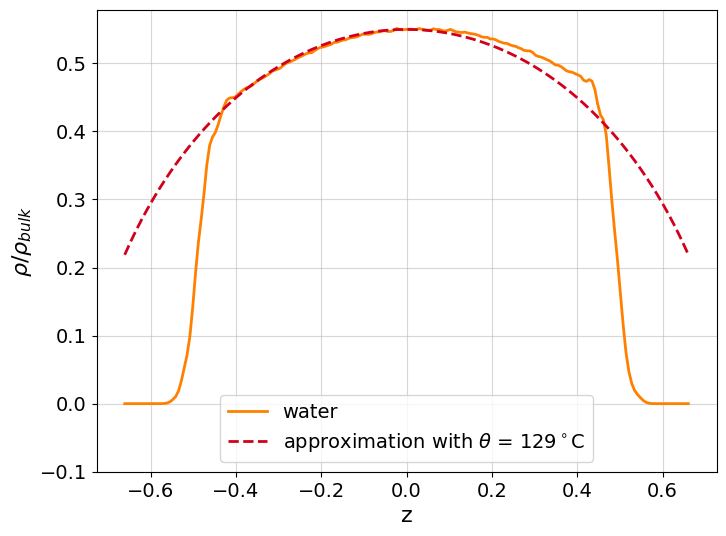

In [24]:
plt.figure(figsize=(8, 6))

plt.grid(alpha=0.5)
plt.plot(
    zeta, dens,
    label='water',
    color='#FF8000',
    linewidth=2
)

plt.plot(
    zeta, rho_roll_approx(zeta, l, phi, best['theta']) + best['offset'],
    label=r'approximation with $\theta$ = {}$^\circ$C'.format(int(np.rad2deg(best["theta"]))),
    # color='#00B400',
    color='#D2001B',
    linewidth=2,
    linestyle='dashed'
)

# plt.xlim(-0.9, 0.9)
# plt.ylim(-0.75, 0.75)
plt.xlabel('z', fontsize=16)
plt.ylabel(r'$\rho / \rho_{bulk}$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.ylim(bottom=-0.1)
# plt.show()
plt.savefig('img/density_profile_calcite_dodecane.eps')

---

In [22]:
# Для углеводорода
L = 19.65600
H = 20

l = L / H
phi = 0.2

In [23]:
file = 'dens_chexd_z.xvg'

In [24]:
rho_bulk = 33.3277 * 4
z, dens = np.loadtxt(f"data/{file}", comments=["@", "#"], unpack=True)
dens /= rho_bulk
zeta = z / H

In [25]:
left, right = 0, len(zeta)
for i in range(len(zeta)):
    if dens[i] > 0:
        left = i-1
        break

for i in range(len(zeta)-1, -1, -1):
    if dens[i] > 0:
        right = i+1
        break

def error_L1(args):
    return np.sum(np.abs(rho_worm(zeta[left:right], l, phi, args['theta']) - dens[left:right]))

def error_L2(args):
    return np.sum((rho_worm(zeta[left:right], l, phi, args['theta']) - dens[left:right])**2)

trials = Trials()

space = {
    'theta': hp.uniform('theta', np.pi/2, np.pi),
    # 'offset': hp.uniform('offset', -1, 1)
}

best = fmin(
    fn=error_L1,
    space=space,
    algo=tpe.suggest,
    max_evals=2000,
    trials=trials,
    show_progressbar=True
)

print('Best')
print('angle:', '{:.1f}'.format(np.rad2deg(best['theta'])))
# print('offset:', '{:.2f}'.format(best['offset']))

100%|██████████| 2000/2000 [00:06<00:00, 297.23trial/s, best loss: 1.7868699183729433]
Best
angle: 159.8


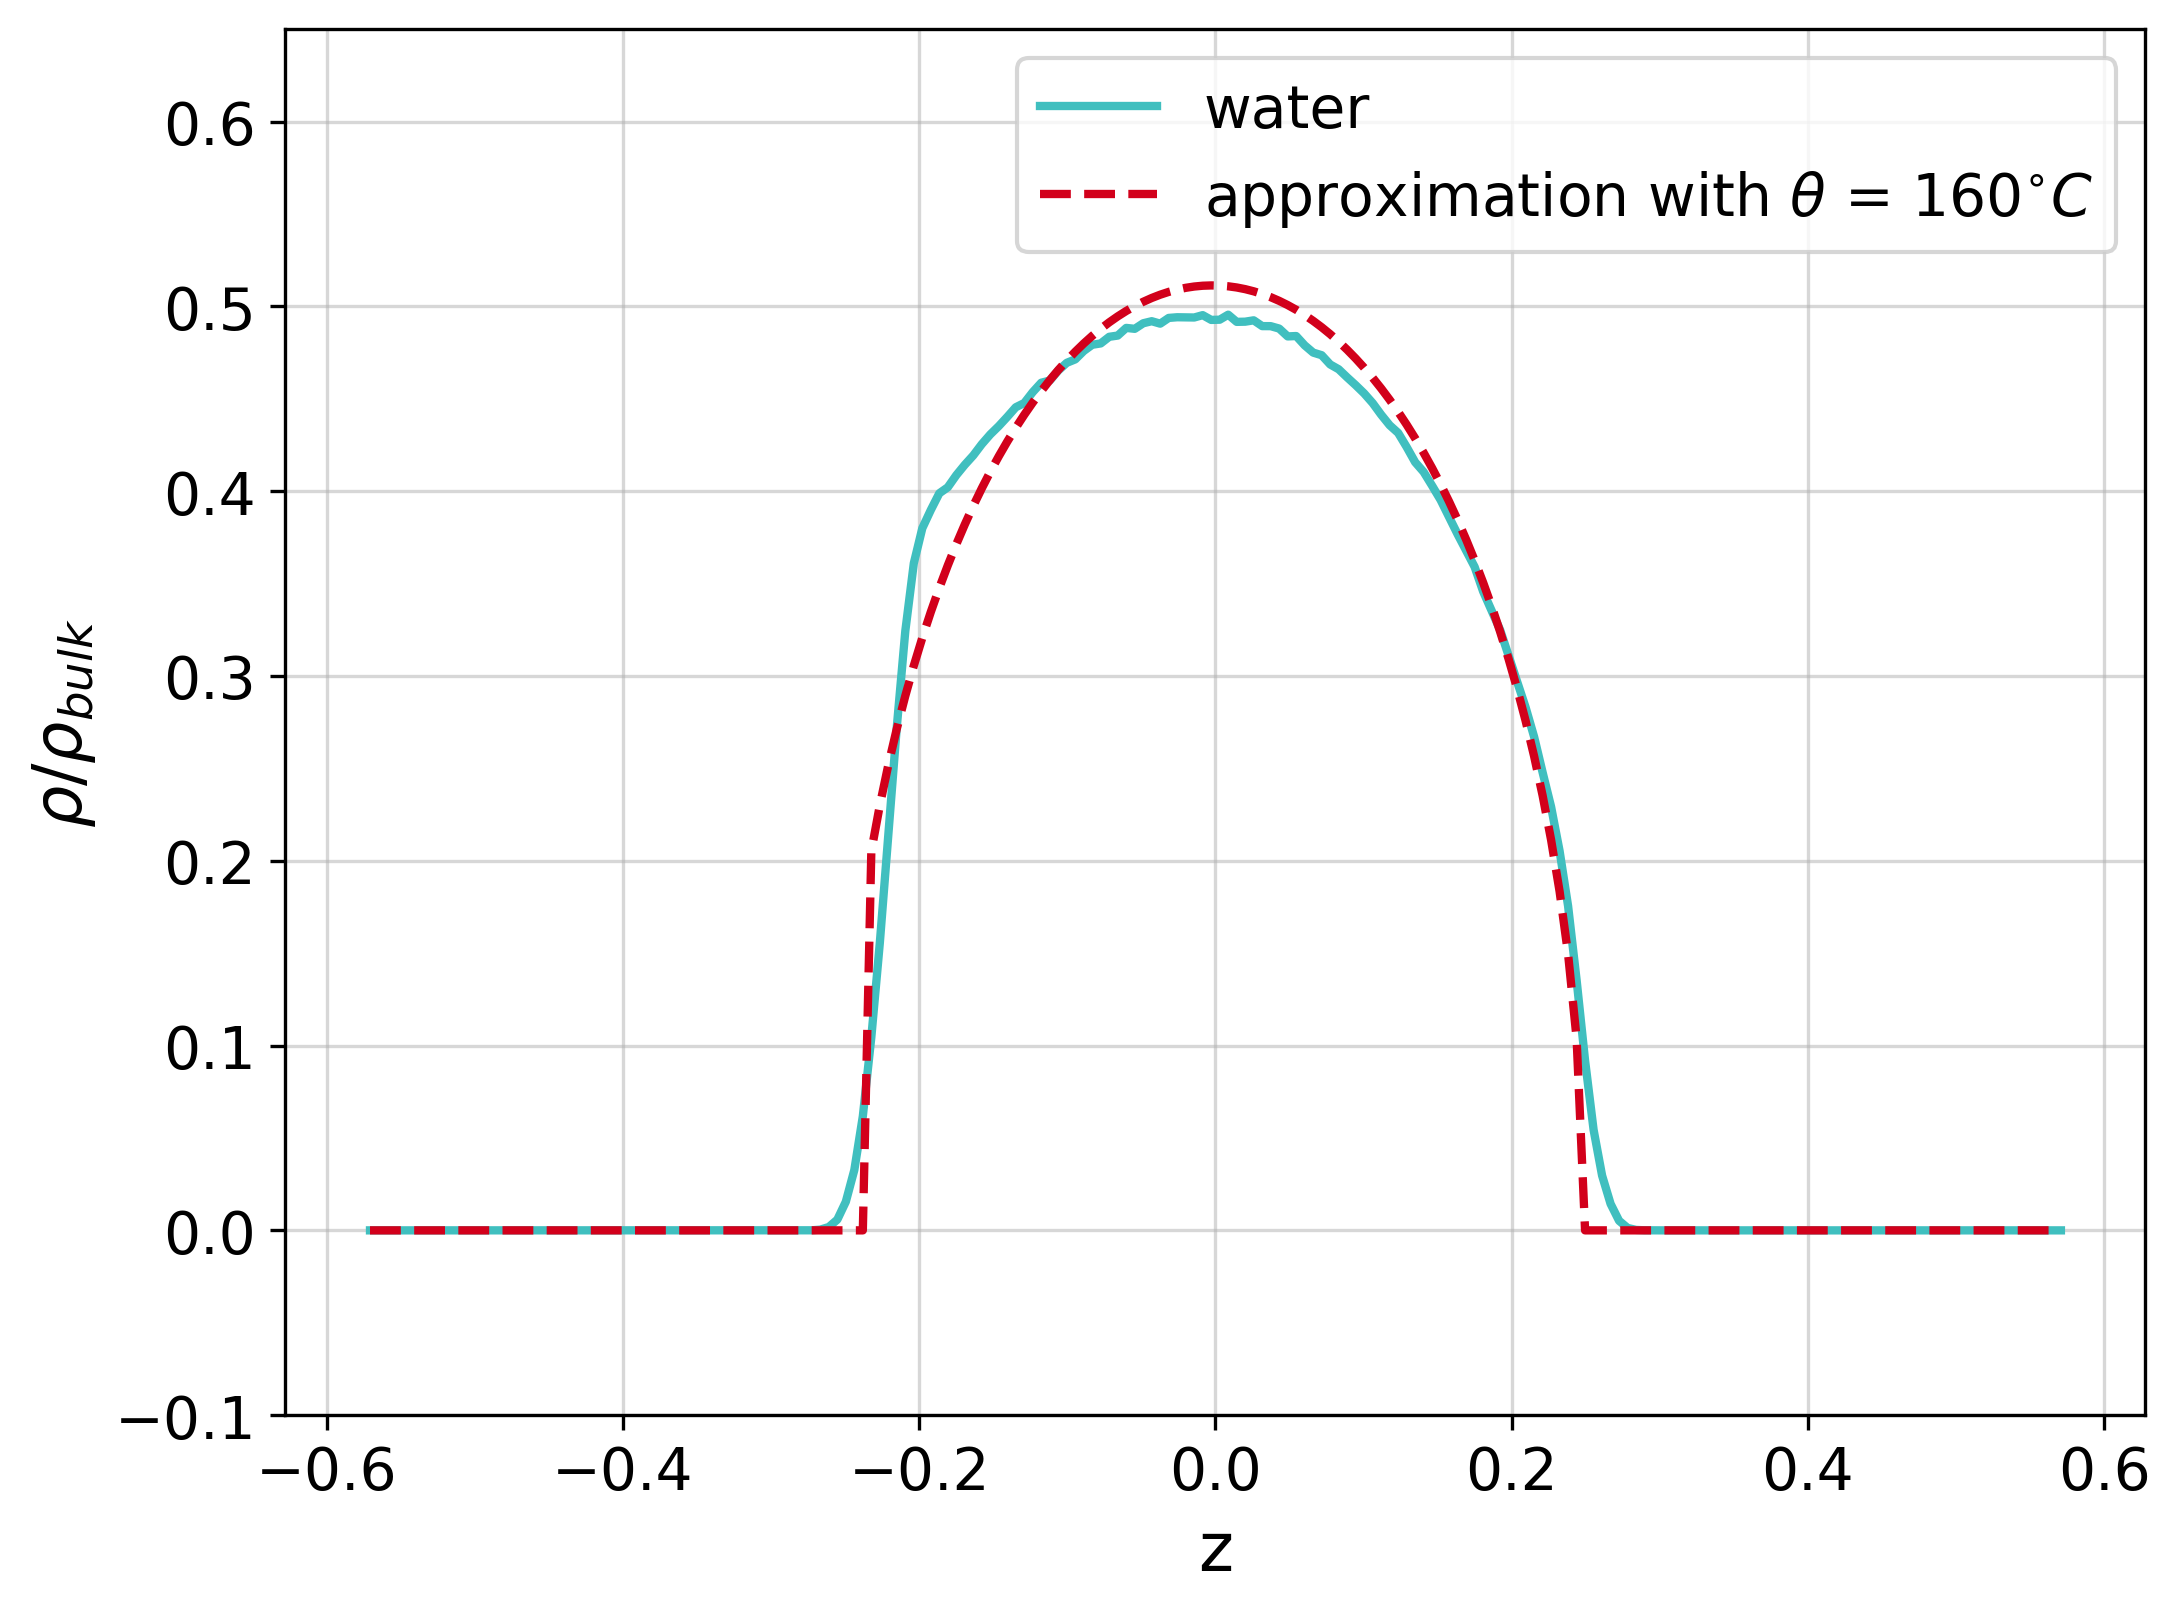

In [26]:
plt.figure(figsize=(8, 6), dpi=300)

plt.grid(alpha=0.5)
plt.plot(
    zeta, dens,
    label='water',
    color='#40BFBF',
    linewidth=2
)

plt.plot(
    zeta, rho_worm(zeta, l, phi, best['theta']),
    label=r'approximation with $\theta$ = 160$^{\circ}C$',
    color='#D2001B',
    linewidth=2,
    linestyle='dashed'
)

# plt.xlim(-0.9, 0.9)
plt.ylim(-0.5, 0.65)
plt.xlabel('z', fontsize=16)
plt.ylabel(r'$\rho / \rho_{bulk}$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=1, fontsize=14)
plt.ylim(bottom=-0.1)
plt.show()